In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample




In [49]:
df = pd.read_csv('dataset/depression_anxiety_data.csv')


In [2]:
print("Initial Data Overview:")
print(f"Shape: {df.shape}")


Initial Data Overview:
Shape: (783, 19)


In [3]:
print("\nData Types:")
print(df.dtypes)



Data Types:
id                        int64
school_year               int64
age                       int64
gender                   object
bmi                     float64
who_bmi                  object
phq_score                 int64
depression_severity      object
depressiveness           object
suicidal                 object
depression_diagnosis     object
depression_treatment     object
gad_score                 int64
anxiety_severity         object
anxiousness              object
anxiety_diagnosis        object
anxiety_treatment        object
epworth_score           float64
sleepiness               object
dtype: object


In [4]:
print("\nMissing Values:")
print(df.isna().sum())


Missing Values:
id                      0
school_year             0
age                     0
gender                  0
bmi                     0
who_bmi                 0
phq_score               0
depression_severity     4
depressiveness          3
suicidal                1
depression_diagnosis    1
depression_treatment    4
gad_score               0
anxiety_severity        0
anxiousness             6
anxiety_diagnosis       4
anxiety_treatment       2
epworth_score           8
sleepiness              8
dtype: int64


In [5]:
df_clean = df.drop(columns=['id']).dropna()
gender_mapping = {'male': 1, 'female': 0}
df_clean['gender'] = df_clean['gender'].map(gender_mapping)

binary_cols = ['depressiveness', 'suicidal', 'depression_diagnosis',
               'depression_treatment', 'anxiousness', 'anxiety_diagnosis',
               'anxiety_treatment', 'sleepiness']

for col in binary_cols:
    df_clean[col] = df_clean[col].astype(int)

In [6]:
df_clean['treatment_status'] = df_clean['depression_treatment'] | df_clean['anxiety_treatment']
df_clean['severity_index'] = df_clean['phq_score'] + df_clean['gad_score']

cat_cols = ['who_bmi', 'depression_severity', 'anxiety_severity']
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)


In [ ]:
tech_survey = pd.read_csv('dataset/survey.csv')

tech_survey_clean = tech_survey.rename(columns={
    'treatment': 'depression_treatment',
    'work_interfere': 'functional_impairment'
})[['Age', 'Gender', 'functional_impairment', 'depression_treatment']]

## Exploratory Data Analysis

#### A. Target Variable Distribution

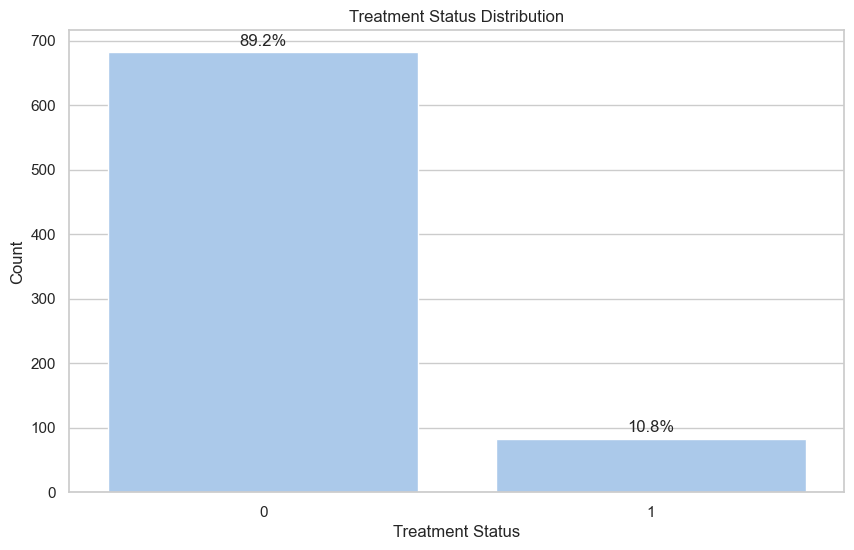

In [18]:
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='treatment_status', data=df_clean)
plt.title('Treatment Status Distribution')
plt.xlabel('Treatment Status')
plt.ylabel('Count')

total = len(df_clean)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 10
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

#### B. PHQ-GAD Score Distribution


<Figure size 1200x600 with 0 Axes>

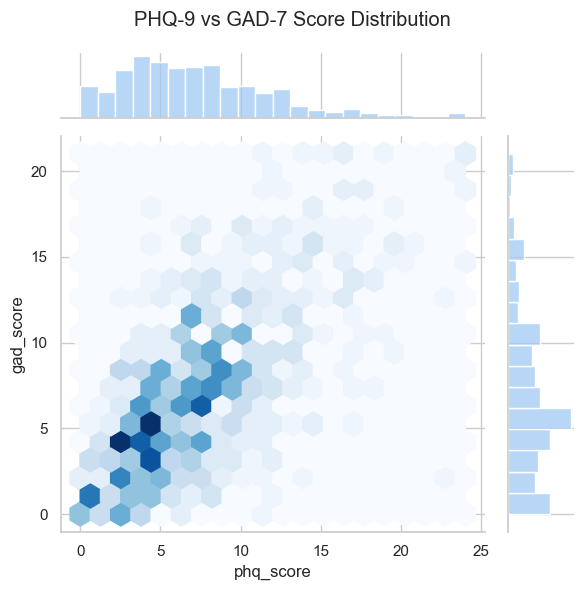

In [19]:
plt.figure(figsize=(12, 6))
sns.jointplot(x='phq_score', y='gad_score', data=df_clean, 
             kind='hex', cmap='Blues')
plt.suptitle('PHQ-9 vs GAD-7 Score Distribution')
plt.tight_layout()
plt.show()

### C. Demographic Analysis


/var/folders/9k/h2vg5w254k129wvd25jsbcm00000gn/T/ipykernel_14945/2990995965.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['Female', 'Male'])


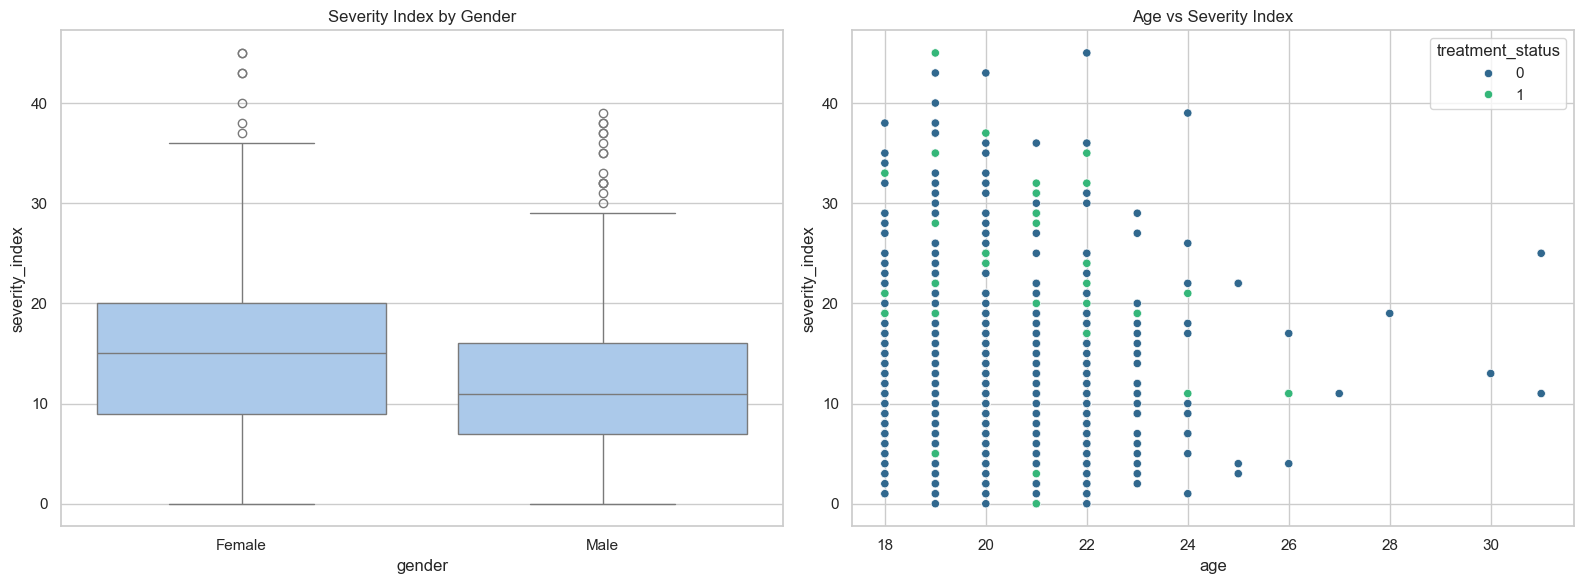

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='gender', y='severity_index', data=df_clean, ax=ax[0])
ax[0].set_title('Severity Index by Gender')
ax[0].set_xticklabels(['Female', 'Male'])

sns.scatterplot(x='age', y='severity_index', hue='treatment_status',
                data=df_clean, ax=ax[1], palette='viridis')
ax[1].set_title('Age vs Severity Index')
plt.tight_layout()
plt.show()

# 5. Correlation Analysis


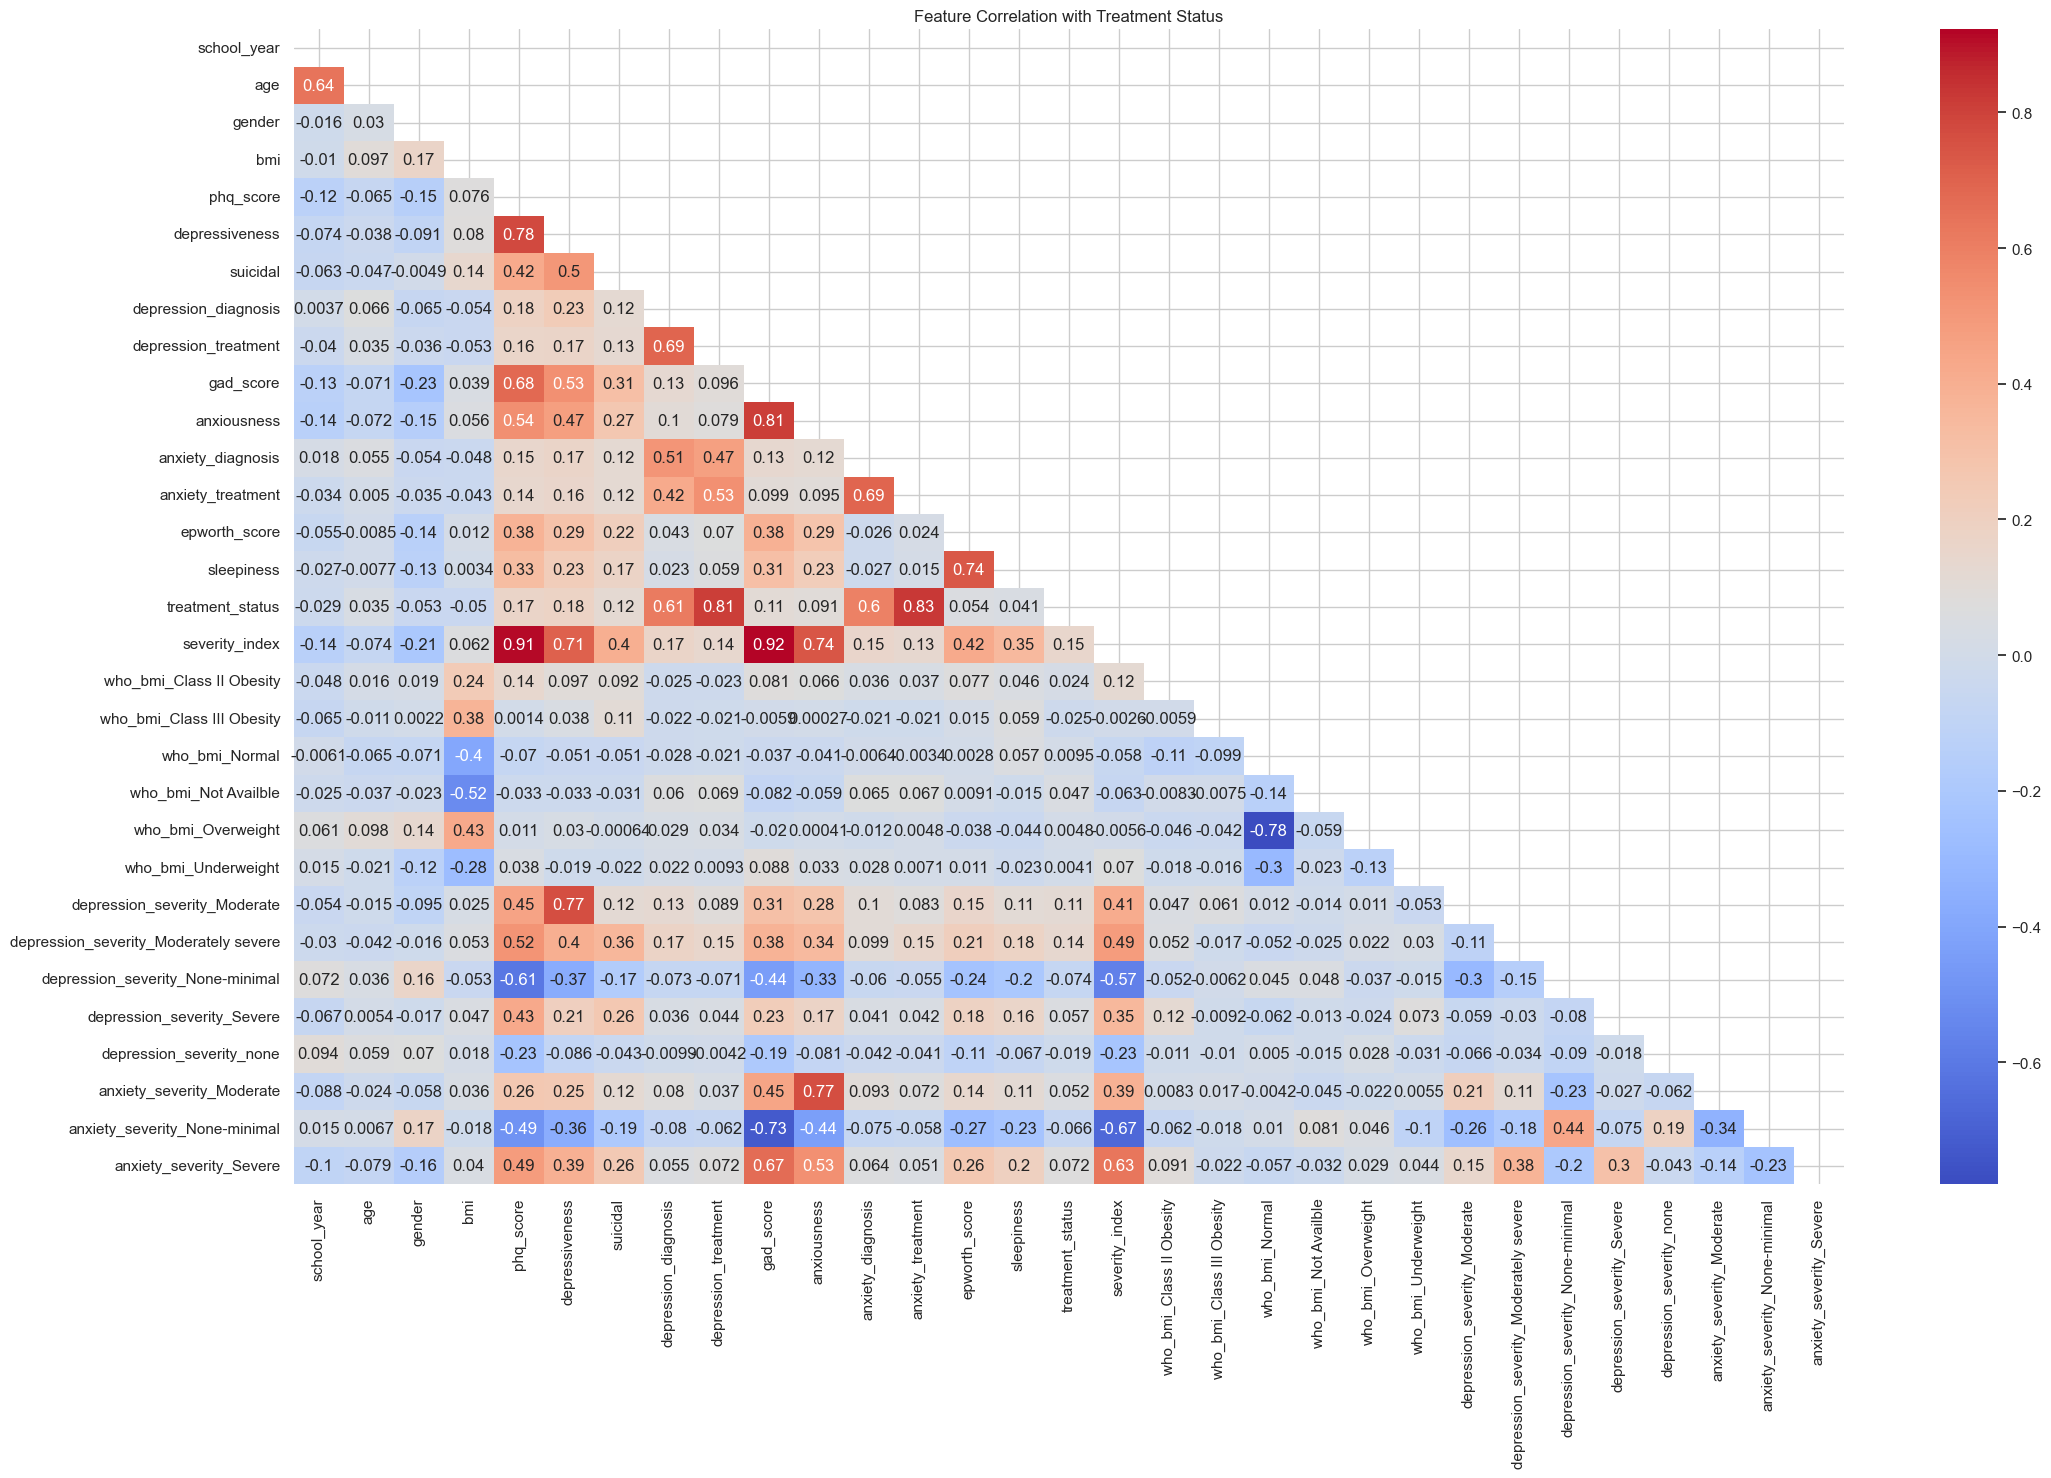

In [21]:
plt.figure(figsize=(25, 15))
corr_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Feature Correlation with Treatment Status')
plt.show()

## 6. Model Training & Evaluation


In [22]:
majority_class = df_clean[df_clean['treatment_status'] == 0]
minority_class = df_clean[df_clean['treatment_status'] == 1]

minority_oversampled = resample(minority_class,
                                replace=True,
                                n_samples=len(majority_class),
                                random_state=42)

df_balanced = pd.concat([majority_class, minority_oversampled])

In [23]:
X = df_balanced[['phq_score', 'gad_score', 'gender', 'age']]
y = df_balanced['treatment_status']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=42)

In [24]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.58      0.61      0.59       144
           1       0.54      0.50      0.52       129

    accuracy                           0.56       273
   macro avg       0.56      0.56      0.56       273
weighted avg       0.56      0.56      0.56       273



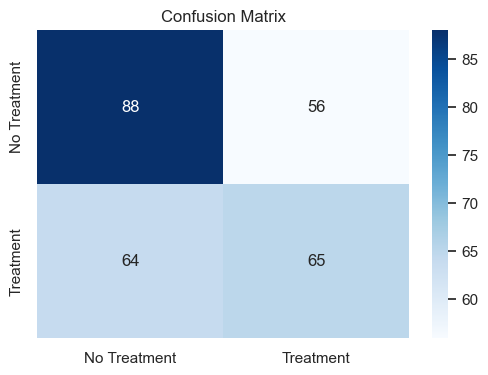

In [25]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Treatment', 'Treatment'],
            yticklabels=['No Treatment', 'Treatment'])
plt.title('Confusion Matrix')
plt.show()

In [26]:
combined_df = pd.concat([df_clean, tech_survey_clean], axis=0)


## Combining the Datasets

In [27]:
# B. Enhanced Missing Value Handling (Replace simple dropna)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Create imputation pipeline
imputer = IterativeImputer(max_iter=10, random_state=42)
num_cols = ['phq_score', 'gad_score', 'age', 'epworth_score']
combined_df[num_cols] = imputer.fit_transform(combined_df[num_cols])

In [28]:
conditions = [
    (combined_df['depression_diagnosis'] == 0) & (combined_df['anxiety_diagnosis'] == 0),
    (combined_df['depression_diagnosis'] == 1) & (combined_df['anxiety_diagnosis'] == 0),
    (combined_df['depression_diagnosis'] == 0) & (combined_df['anxiety_diagnosis'] == 1),
    (combined_df['depression_diagnosis'] == 1) & (combined_df['anxiety_diagnosis'] == 1)
]
combined_df['diagnosis_class'] = np.select(conditions, [0, 1, 2, 3])

In [29]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [30]:

X = combined_df[['phq_score', 'gad_score', 'gender', 'age', 'epworth_score']]
y = combined_df['diagnosis_class']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weight = class_weights[1] / class_weights[0]


In [32]:
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

In [33]:
from sklearn.metrics import roc_auc_score,f1_score

In [34]:
X

,phq_score,gad_score,gender,age,epworth_score
0,9.00000,11.000000,1.0,19.000000,7.000000
1,8.00000,5.000000,1.0,18.000000,14.000000
2,8.00000,6.000000,1.0,19.000000,6.000000
3,19.00000,15.000000,0.0,18.000000,11.000000
4,6.00000,14.000000,1.0,18.000000,3.000000
...,...,...,...,...,...
1254,7.16732,6.882353,NaN,20.257516,6.396078
1255,7.16732,6.882353,NaN,20.257516,6.396078
1256,7.16732,6.882353,NaN,20.257516,6.396078
1257,7.16732,6.882353,NaN,20.257516,6.396078


In [35]:
# Impute missing values
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

results = []
for name, model in models.items():
    model.fit(X_train_imputed, y_train)
    y_pred = model.predict(X_test_imputed)
    probas = model.predict_proba(X_test_imputed)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, probas, multi_class='ovo'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted')
    })

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:49:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [36]:
results_df = pd.DataFrame(results)
print(results_df.sort_values('ROC-AUC', ascending=False))

                 Model  Accuracy   ROC-AUC  F1-Score
0        Random Forest  0.958025  0.693357  0.937487
1              XGBoost  0.943210  0.673291  0.930027
2  Logistic Regression  0.955556  0.589851  0.936251


In [37]:

import shap

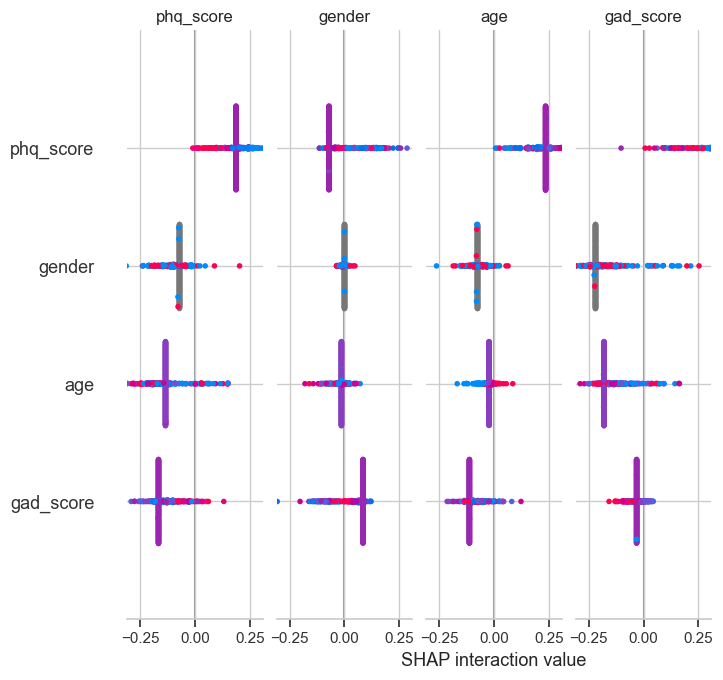

In [43]:

explainer = shap.TreeExplainer(models["Random Forest"])
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [39]:
combined_df['severity_tier'] = pd.cut(
    combined_df['phq_score'] + combined_df['gad_score'],
    bins=[0, 10, 20, 30],
    labels=['Mild', 'Moderate', 'Severe']
)

## Save the model

In [40]:
import joblib
from sklearn.pipeline import Pipeline

In [47]:
pipeline = Pipeline([
    ('imputer', imputer),
    ('model', models["Random Forest"])
])

In [48]:
joblib.dump(pipeline, 'mental_health_model.pkl')


['mental_health_model.pkl']